# Oscillating Star Formation with OMEGA+

Prepared by Benoit Côté

This notebook introduces the development of oscillating behaviours in the star formation history of a galaxy using OMEGA+.

In [2]:
# Import Python modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Import chemical evolution codes
import omega_plus
import omega
import sygma

## 1. Prepare for the Fast Version of the Code

For information regarding using the fast version, please click <a href="https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Fast_chem_evol.ipynb">here</a>.

For information regarding using the timestep size management, please click <a href="https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb">here</a>.

In [4]:
# Timestep sizes for the pre-calculated simple stellar populations (SSPs)
dt = 2e7
sp = 600
dt_split_info = [[2e5,1e8],[1e7,0.5e9],[1e8,13e9]]
s_dt_template = sygma.sygma(dt_split_info=dt_split_info)

# Copy the SSP timestep array
dt_in_SSPs = s_dt_template.history.timesteps

SYGMA run in progress..
   SYGMA run completed - Run time: 6.39s


In [5]:
# Selection of stellar yields table
# This is a dummy yields table with hydrogen only,
# which is used to accelerate the computation when
# only want to probe the star formation process.
table = 'yield_tables/agb_and_massive_stars_h1.txt'
Z_trans = -1
popIII_info_fast = False

# Let's pre-calculate the SSPs for the fast version
o_for_SSPs = omega.omega(special_timesteps=2, pre_calculate_SSPs=True, dt_in_SSPs=dt_in_SSPs, \
             Z_trans=Z_trans, table=table)

# Let's copy the SSPs array
SSPs_in = [o_for_SSPs.ej_SSP, o_for_SSPs.ej_SSP_coef, o_for_SSPs.dt_ssp, o_for_SSPs.t_ssp]

OMEGA run in progress..
SYGMA run in progress..
   SYGMA run completed - Run time: 3.41s
SYGMA run in progress..
   SYGMA run completed - Run time: 3.46s
SYGMA run in progress..
   SYGMA run completed - Run time: 3.66s
SYGMA run in progress..
   SYGMA run completed - Run time: 3.5s
SYGMA run in progress..
   SYGMA run completed - Run time: 3.56s
Warning -- Not enough gas to sustain the SFH. 2
   OMEGA run completed - Run time: 18.99s


In [6]:
# Calculate the number of CC SNe per unit of stellar mass formed
A = 1.0 / o_for_SSPs._imf(o_for_SSPs.imf_bdys[0],o_for_SSPs.imf_bdys[1],2)
nb_ccsne_per_m = A * o_for_SSPs._imf(o_for_SSPs.transitionmass,o_for_SSPs.imf_yields_range[1],1)
print 'Number of CC SNe per unit of Msun formed:', '%.2E' %nb_ccsne_per_m

Number of CC SNe per unit of Msun formed: 9.49E-03


## 2. Impact of the Star Formation Efficiency

Here we explore the impact of the star formation efficiency (SFE) on the star formation history (SFH) of a dwarf galaxy.  By increasing the SFE, an originally smooth and stable SFH can turn into an episodic SFH, as long as proper delay times are considered for supernova feedback, as shown below and in Section 3.

This is a demonstrative case.  It is not aimed to reproduce a particular observed galaxy.

In [7]:
# Define the different SFE to be explored
sfe_arr = [0.3, 0.15, 0.075, 0.04]
len_sfe = len(sfe_arr)
t_star = 1e7

#### Run OMEGA+ Simulations

In [8]:
# SNe will release their energy between 5 and 40 Myr after
# the formation of the progenitor stars
sne_L_feedback=[5e6,4e7]

# Run the models
# Should compute for less than a minute
op_arr = []
for i in range(len_sfe):
    op_arr.append( omega_plus.omega_plus( mgal=1.0, dt=5.0e5, tend=5.0e8, special_timesteps=-1, \
                   pre_calculate_SSPs=True, SSPs_in=SSPs_in, table=table, Z_trans=Z_trans, \
                   popIII_info_fast=popIII_info_fast, sne_L_feedback=sne_L_feedback, \
                   nb_ccsne_per_m=nb_ccsne_per_m, t_sf_z_dep=0.0, mass_loading=5.0, \
                   f_t_ff=5.0, m_DM_0=1.0e8, print_off=True, t_star=t_star, sfe=sfe_arr[i]))

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 3.38s
   OMEGA+ run completed - Run time: 3.38s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 4.0s
   OMEGA+ run completed - Run time: 4.0s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 3.96s
   OMEGA+ run completed - Run time: 3.96s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 3.99s
   OMEGA+ run completed - Run time: 3.99s


#### Plot the Star Formation Histories

<IPython.core.display.Javascript object>


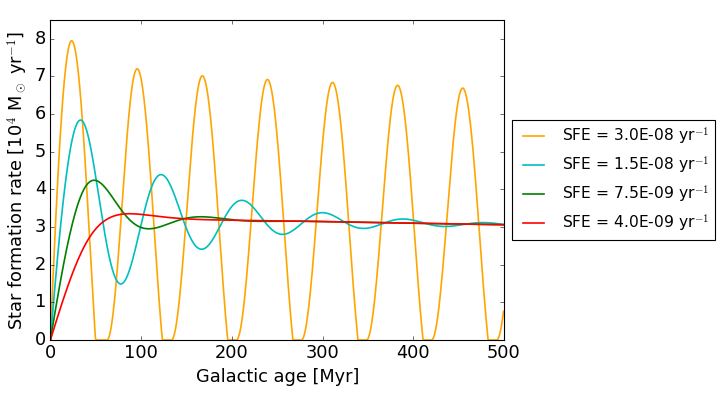

(0, 8.5)

In [9]:
# Set figure frame
%matplotlib nbagg
plt.figure(figsize=(9,5))

# Select colors and linestyles
c = ['orange', 'c', 'g', 'r']
ls = ['-', '-', '-', '-']

# Plot the SFH as a function of the SFE
for i in range(len_sfe):
    plt.plot(np.array(op_arr[i].inner.history.age)/1.0e6, \
             np.array(op_arr[i].inner.history.sfr_abs)*1.0e4, \
             linewidth=1.5, color=c[i], linestyle=ls[i], \
             label='SFE = '+str('%.1E' %(sfe_arr[i]/t_star))+' yr$^{-1}$')
    
# Set labels and visual
matplotlib.rcParams.update({'font.size': 16})
plt.xlabel('Galactic age [Myr]', fontsize=16)
plt.ylabel('Star formation rate [10$^4$ M$_\odot$ yr$^{-1}$]', fontsize=16)
plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.07)
plt.subplots_adjust(right=0.7)
plt.subplots_adjust(bottom=0.15)
plt.ylim(0,8.5)

As shown in the plot above, there are 3 distinct star formation behaviours:

- Stable (low SFE, red line),
- Oscillating (moderate SFE, green and blue lines),
- Episodic (high SFE, orange line).

With a higher SFE, less gas is needed to form a particular quantity of stars, which means that the stellar-to-gas mass ratio in the galactic gas gets higher.  Since the mass ejected by the galactic outflow is tied to the magnitude of the star formation rate, systems with higher SFEs (with less gas) will thus be more affected by outflows.  These outflows can, in certain cases, empty the galactic gas reservoir (see orange line).

#### Plot the Mass of Gas Inside the Dwarf Galaxy

<IPython.core.display.Javascript object>


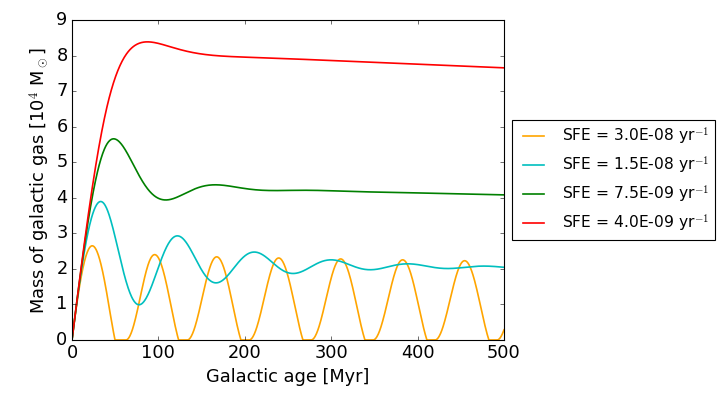

In [10]:
# Set figure frame
%matplotlib nbagg
plt.figure(figsize=(9,5))

# For each choice of SFE ..
for i in range(len_sfe):
    
    # Calculate the total mass inside the galaxy
    m_ism_tot = np.zeros(op_arr[i].inner.nb_timesteps+1)
    for i_t in range(op_arr[i].inner.nb_timesteps+1):
        m_ism_tot[i_t] = sum(op_arr[i].inner.ymgal[i_t])
    
    # Plot the total mass inside the galaxy
    plt.plot(np.array(op_arr[i].inner.history.age)/1.0e6, m_ism_tot/1.0e4, \
             linewidth=1.5, color=c[i], linestyle='-', \
             label='SFE = '+str('%.1E' %(sfe_arr[i]/t_star))+' yr$^{-1}$')
    
# Set labels and visual
matplotlib.rcParams.update({'font.size': 16})
plt.xlabel('Galactic age [Myr]', fontsize=16)
plt.ylabel('Mass of galactic gas [10$^4$ M$_\odot$]', fontsize=16)
plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.7)
plt.subplots_adjust(bottom=0.15)

#### Plot the Stability-Analysis Plot

In [11]:
# Calculate the rate of change of the circumgalactic gas mass (hot gas reservoir)
dm_cgm = []
for i in range(len_sfe):
    dm_cgm.append((op_arr[i].inner.m_outflow_t - op_arr[i].inner.m_inflow_t) / \
                   op_arr[i].inner.history.timesteps)
    
# Calculate the total mass of gas present inside the entire system
m_tot = []
for i in range(len_sfe):
    m_tot.append(np.zeros(op_arr[i].inner.nb_timesteps))
    for i_t in range(op_arr[i].inner.nb_timesteps):
        m_tot[i][i_t] = sum(op_arr[i].ymgal_outer[i_t]) / \
                       (sum(op_arr[i].inner.ymgal[i_t])+sum(op_arr[i].ymgal_outer[i_t]))

<IPython.core.display.Javascript object>


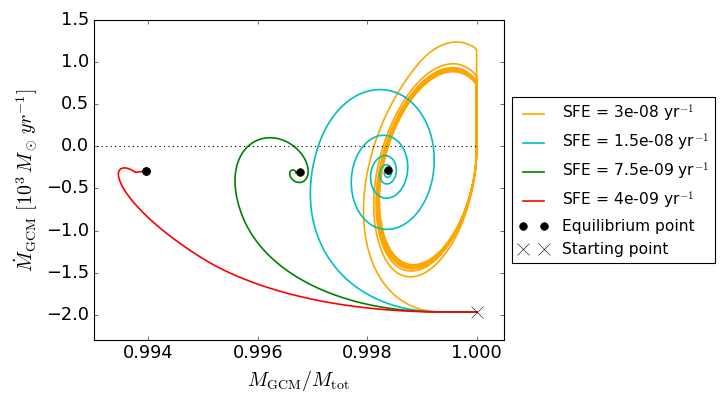

In [12]:
# Set figure frame
%matplotlib nbagg
plt.figure(figsize=(9,5))

# For each choice of SFE ..
for i in range(len_sfe):
        
    # Plot the stability-analysis plot
    plt.plot(m_tot[i], dm_cgm[i]*1.0e3, \
             linewidth=1.5, color=c[i], linestyle='-', label='SFE = '+str(sfe_arr[i]/t_star)+' yr$^{-1}$')

# Mark equilibrium point
for i in range(1,len_sfe):
    plt.plot([m_tot[i][-1]], [dm_cgm[i][-1]*1.0e3], 'ok', ms=7, zorder=1000)
plt.plot([m_tot[i][-1]], [dm_cgm[i][-1]*1.0e3], 'ok', ms=7, zorder=1000, label='Equilibrium point')

# Mark the starting point
plt.plot([m_tot[0][0]], [dm_cgm[0][0]*1.0e3], 'xk', ms=10, label='Starting point')
plt.plot([0,1], [0,0], ':k')

# Set labels and visual
matplotlib.rcParams.update({'font.size': 16})
plt.xlabel('$M_\mathrm{GCM}/M_\mathrm{tot}$', fontsize=18)
plt.ylabel('$\dot{M}_\mathrm{GCM}$ $[10^3\,M_\odot\,yr^{-1}]$', fontsize=18)
plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.13)
plt.subplots_adjust(right=0.7)
plt.subplots_adjust(bottom=0.15)
plt.xlim(0.993,1.0005)
aa = plt.ylim(-2.3,1.5)
aa = plt.xticks([0.994, 0.996, 0.998, 1.0])

The plot above shows $\dot{M}_\mathrm{GCM}$, the rate of change in the gas mass of the circumgalactic medium (CGM, hot gas reservoir surrounding the galaxy), as a function of $M_\mathrm{GCM}/M_\mathrm{tot}$, the ratio between the mass of the CGM and the total mass of gas present in the system (GCM + galactic gas). When $\dot{M}_\mathrm{GCM}$ is negative, galactic inflows are dominating over outflows.  When $\dot{M}_\mathrm{GCM}$ is positive, galactic outflows are dominating over inflows.

The black cross represents the starting point at the beginning of all simulations.  The black dots illustrate the equilibrium point of the star formation process, which depends on the adopted SFE.

**Stable SFH -** With a low SFE, the SFH is smooth and the system goes directly to the equilibrium point (red line).

**Oscillating SFH -** With a moderate SFE, the SFH is originally oscillating, but the system eventually converges to it's equilibrium point (green and blue lines).  Each oscillation motion (one period) in the SFH translates to a circular motion (one orbit) in the stability-analysis plot.

**Episodic SFH -** When the SFE is high enough, the equilibrium point is at out of reach and the SFH is episodic (the galactic gas periodically gets emptied by galactic outflows).

## 3. Impact of Including Delay Times for SNe Feedback

To generate an oscillating (or episodic) SFH with a simple model like OMEGA+, there needs to be a delay between the formation of stars and the onset of galactic outflows, as in the examples shown in Section 2 (see also Section 5.2.1 in <a href="http://adsabs.harvard.edu/abs/2015ApJ...802..123C">Côté et al. 2015</a>).  Between the moment stars start to form, and the moment kinetic energy is released by SNe, the system is *accumulating* potential energy to generate outflows.  With a sufficiently high SFE (orange lines in Section 2), the potential energy is succicient to remove all the gas inside the galactic component.  This shuts down the star formation process until all massive stars are dead, after which part of the CGM gas can fall back again inside the galaxy to start another cycle.

However, when there is no delay (the galactic outflow rate is proportional to the star formation rate), the system never accumulates potential energy and thus always falls in the stable mode, as shown in the example below

In [13]:
# Remove the delay between the formation of stars and the onset of the galactic outflow
sne_L_feedback=[]

# Run the models
# Should compute for about 1 minute
op_arr_no = []
for i in range(len_sfe):
    op_arr_no.append( omega_plus.omega_plus( mgal=1.0, dt=5.0e5, tend=5.0e8, special_timesteps=-1, \
                   pre_calculate_SSPs=True, SSPs_in=SSPs_in, table=table, Z_trans=Z_trans, \
                   popIII_info_fast=popIII_info_fast, sne_L_feedback=sne_L_feedback, \
                   nb_ccsne_per_m=nb_ccsne_per_m, t_sf_z_dep=0.0, mass_loading=5.0, \
                   f_t_ff=5.0, m_DM_0=1.0e8, print_off=True, t_star=t_star, sfe=sfe_arr[i]))

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 4.0s
   OMEGA+ run completed - Run time: 4.01s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 3.79s
   OMEGA+ run completed - Run time: 3.79s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 3.83s
   OMEGA+ run completed - Run time: 3.83s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 3.8s
   OMEGA+ run completed - Run time: 3.8s


<IPython.core.display.Javascript object>


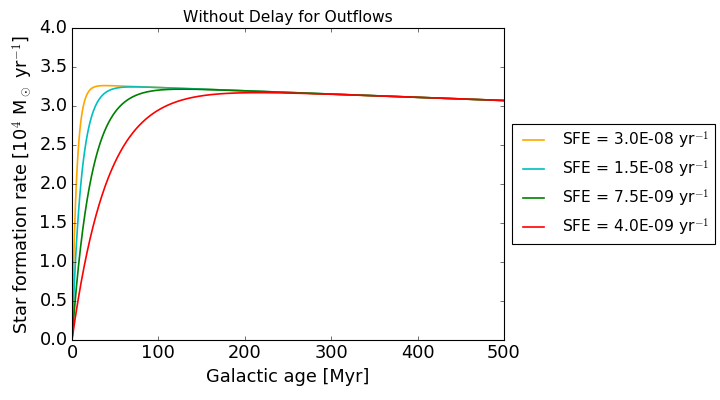

(0, 4)

In [14]:
# Set figure frame
%matplotlib nbagg
plt.figure(figsize=(9,5))

# Select colors and linestyles
c = ['orange', 'c', 'g', 'r']
ls = ['-', '-', '-', '-']

# Plot the SFH as a function of the SFE
for i in range(len_sfe):
    plt.plot(np.array(op_arr_no[i].inner.history.age)/1.0e6, \
             np.array(op_arr_no[i].inner.history.sfr_abs)*1.0e4, \
             linewidth=1.5, color=c[i], linestyle=ls[i], \
             label='SFE = '+str('%.1E' %(sfe_arr[i]/t_star))+' yr$^{-1}$')
    
# Add title
plt.title('Without Delay for Outflows', fontsize=14)
    
# Set labels and visual
matplotlib.rcParams.update({'font.size': 16})
plt.xlabel('Galactic age [Myr]', fontsize=16)
plt.ylabel('Star formation rate [10$^4$ M$_\odot$ yr$^{-1}$]', fontsize=16)
plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.93)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.7)
plt.subplots_adjust(bottom=0.15)
plt.ylim(0,4)